In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


In [3]:
nside = 128
nside1 = 256
A = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(3*nside)
ells1 = np.arange(3*nside1)
freqs = np.linspace(30, 300, 5)*1.e9

In [4]:
#create a filepath to store different power spectra
filepath = '/Users/alex/Documents/foreground_moments/power_spectra/'

In [5]:
#load in the data
PS_2d_const_mean = load(filepath + 'PS_2d_const_mean.npy')
PS_2d_256 = load(filepath + 'PS_2d_256.npy')

In [6]:
# def PS_256():
#     pcls1 = ff.powerlaw(ells1, A, alpha)
#     amp_map1 = hp.synfast(pcls1, nside1, new=True, verbose=False)
#     SED = ff.scale_synch(freqs, beta)
#     data_map1 = amp_map1 * SED[...,np.newaxis]
#     data1 = np.zeros((len(freqs), len(ells1)))
#     for i in range(len(freqs)):
#         data1[i] = hp.anafast(data_map1[i])
#     return data1
    

In [7]:
# #make a mean of 100 PS for nside=256
# N=100
# start=time.time()
# big_mat = np.zeros((N,len(freqs),len(ells1)))
# for i in range(N):
#     if i%5 ==0:
#         print('step ' + str(i))
#     PS = PS_256()
#     big_mat[i,...] = PS
# PS_mean = np.mean(big_mat, 0)
# save(filepath + 'PS_2d_256.npy', PS_mean)
    
# print(time.time()-start)


# Goal here is to fit the 0x0 moment without the weird overshoot at the high ell in the input model

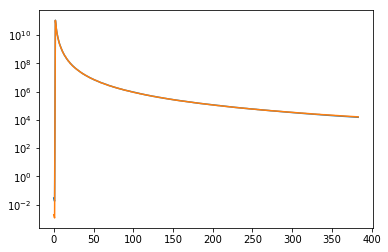

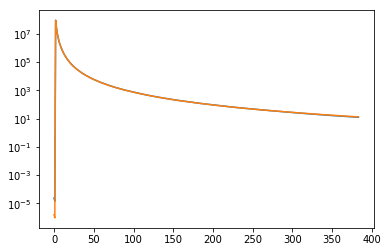

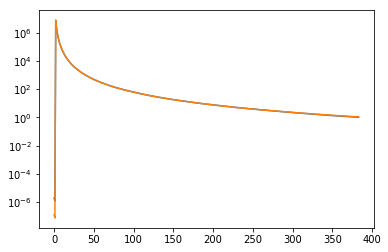

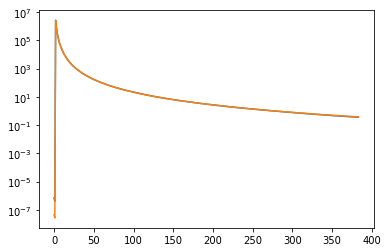

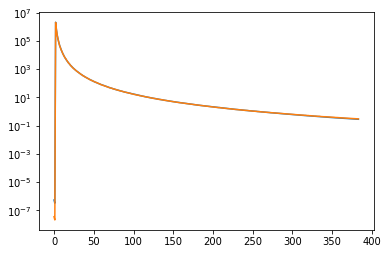

In [8]:
#these are the data I'm trying to model. The 0x0 moment should match them well as these are generated from constant
#beta across the sky.
for i in range(len(freqs)):
    figure()
    semilogy(ells, PS_2d_const_mean[i])
    semilogy(ells, PS_2d_256[i][:384])

# let's start by being super explicit and not using any of the functions in foreground functions except powerlaw and scale_synch

In [9]:
#make some data to model

In [10]:
#make an amplitude map
pcls = ff.powerlaw(ells, A, alpha)
pcls1 = ff.powerlaw(ells1, A, alpha)
amp_map = hp.synfast(pcls, nside, new=True, verbose=False)
amp_map1 = hp.synfast(pcls1, nside1, new=True, verbose=False)

In [11]:
#make an SED to scale this by
SED = ff.scale_synch(freqs, beta)

In [12]:
#make the maps we want to model
data_map = amp_map * SED[...,np.newaxis]
data_map1 = amp_map1 * SED[...,np.newaxis]

In [13]:
#extract powerspectrum to model
data = np.zeros((len(freqs),len(ells)))
for i in range(len(freqs)):
    data[i] = hp.anafast(data_map[i])
    
data1 = np.zeros((len(freqs), len(ells1)))
for i in range(len(freqs)):
    data1[i] = hp.anafast(data_map1[i])

(10000.0, 130000.0)

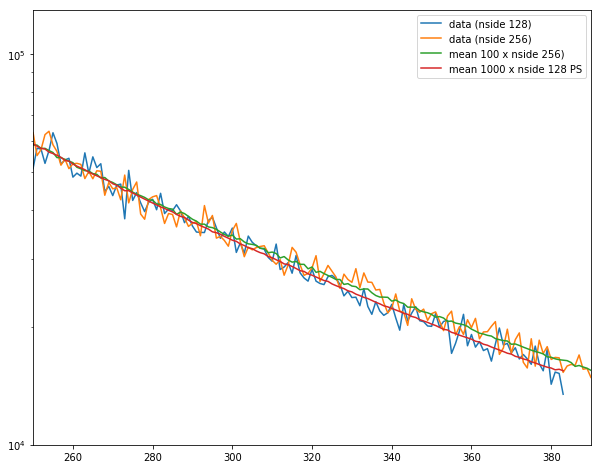

In [14]:
figure(figsize=(10,8))
semilogy(data[0], label='data (nside 128)')
semilogy(data1[0], label='data (nside 256)')
semilogy(PS_2d_256[0], label='mean 100 x nside 256)')
semilogy(PS_2d_const_mean[0], label='mean 1000 x nside 128 PS')
legend();
xlim(250,390)
ylim(1e4,1.3e5)

In [68]:
#okay, so this confirms that the data is being generated and averaged correctly, so that's good and we should
#be trying to fit the averaged curve.

Remember that the model is
$$
0\times0 = SED^2 * C_\ell^A
$$
in the case of auto spectra (where $C_\ell^A$ is the power law in alpha with amplitude A)

In [15]:
#the powerlaw used to generate the map is already calculated and is called the pcls, as is the SED.
#make a new array called model that stores all of these powerspectra
model = np.zeros((len(freqs),len(ells)))
for i in range(len(freqs)):
    model[i] = pcls * SED[i]**2
    
model1 = np.zeros((len(freqs),len(ells1)))
for i in range(len(freqs)):
    model1[i] = pcls1 * SED[i]**2

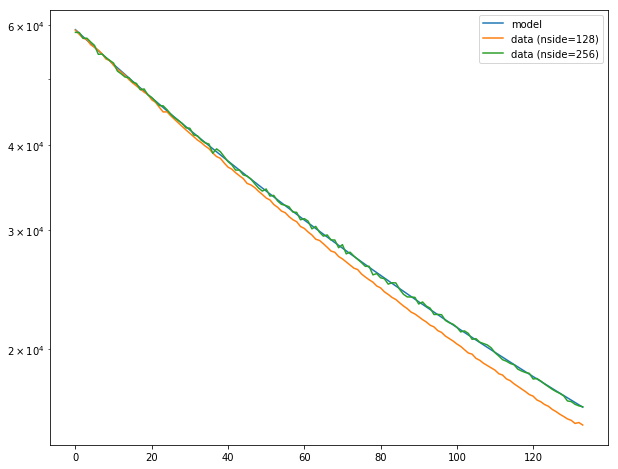

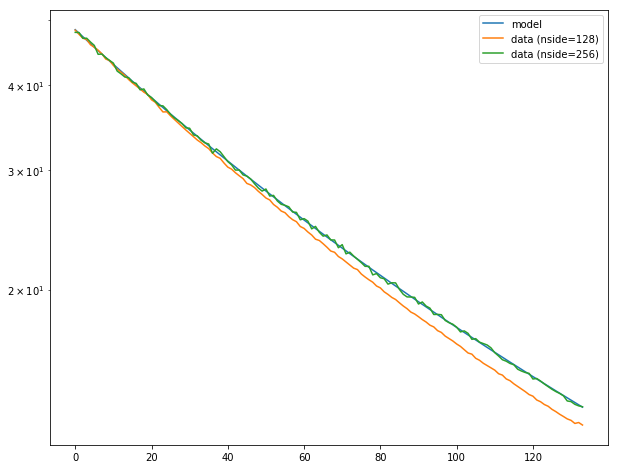

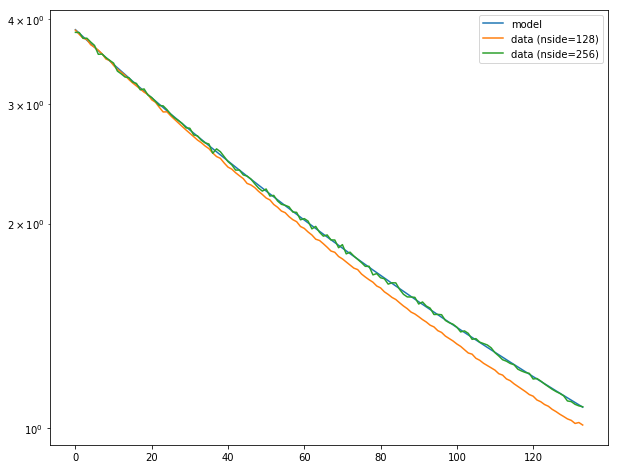

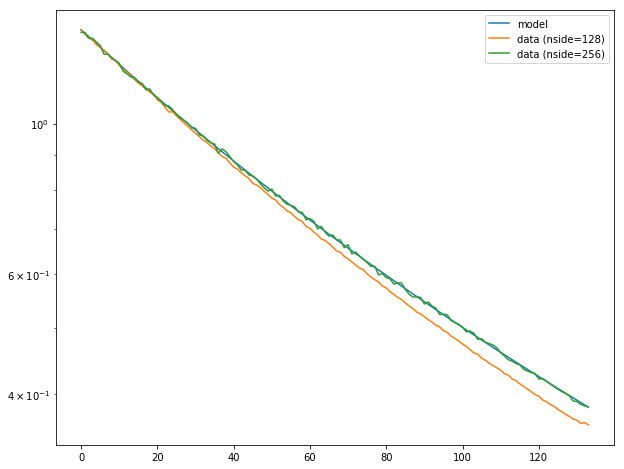

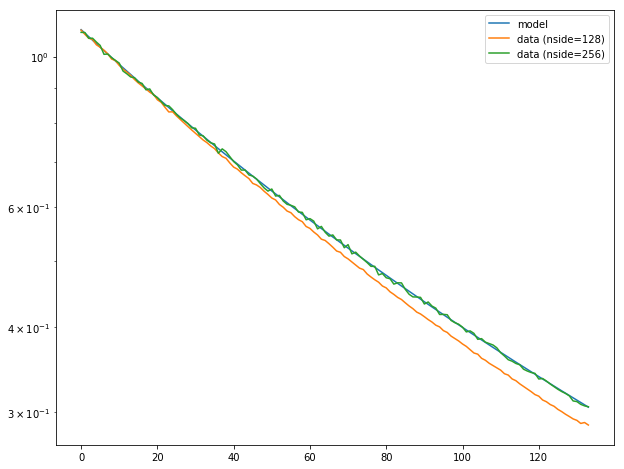

In [16]:
for i in range(len(freqs)):
    figure(figsize=(10,8))
    semilogy(model[i][250:], label='model')
    semilogy(PS_2d_const_mean[i][250:], label='data (nside=128)')
    semilogy(PS_2d_256[i][250:384], label='data (nside=256)')
    legend();

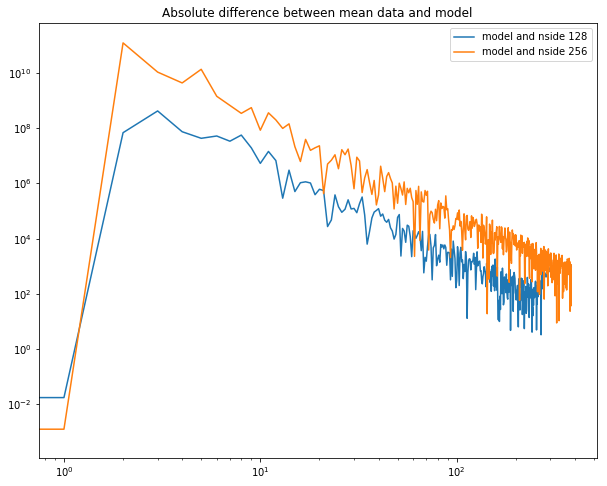

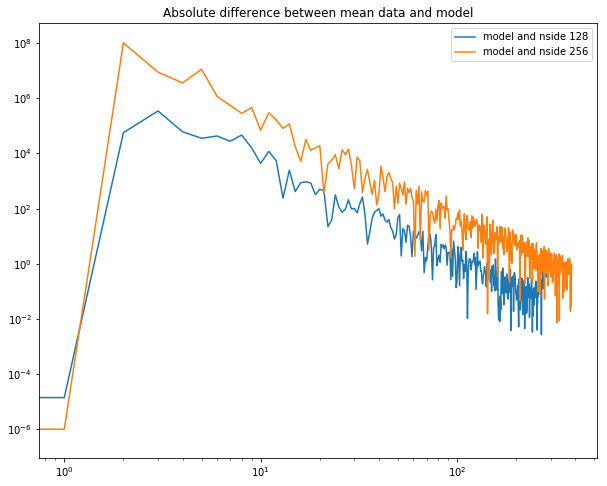

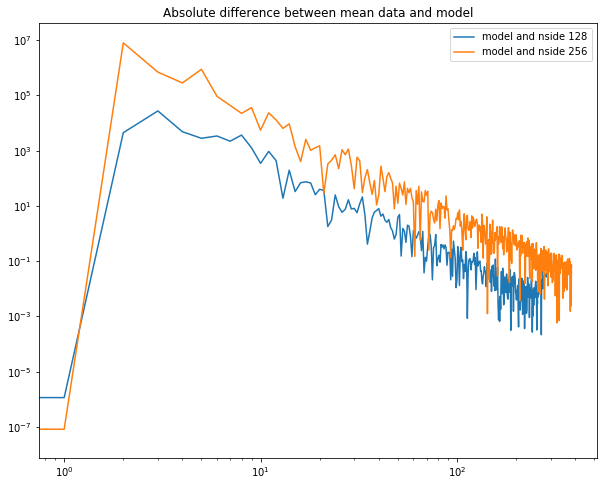

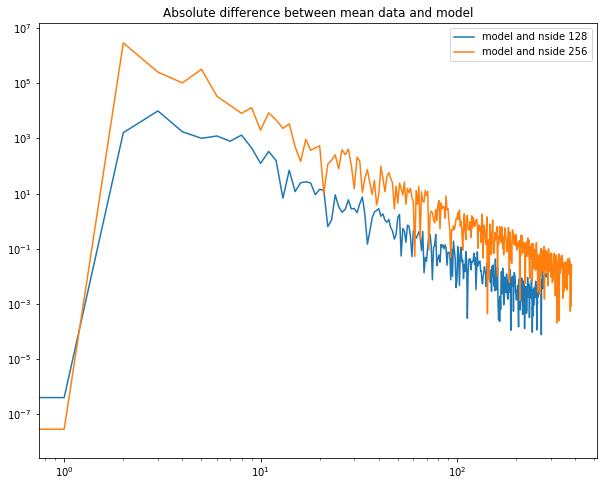

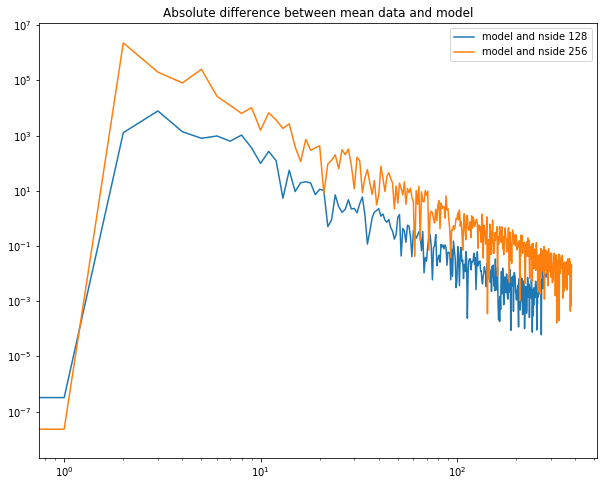

In [18]:
for i in range(len(freqs)):
    figure(figsize=(10,8))
    loglog(ells, np.abs(model[i]-PS_2d_const_mean[i]), label='model and nside 128')
    loglog(ells, np.abs(model[i]-data1[i][:384]), label='model and nside 256')
    title('Absolute difference between mean data and model')
    legend();

In [92]:
#what happens if we look at the full version of the longer one?

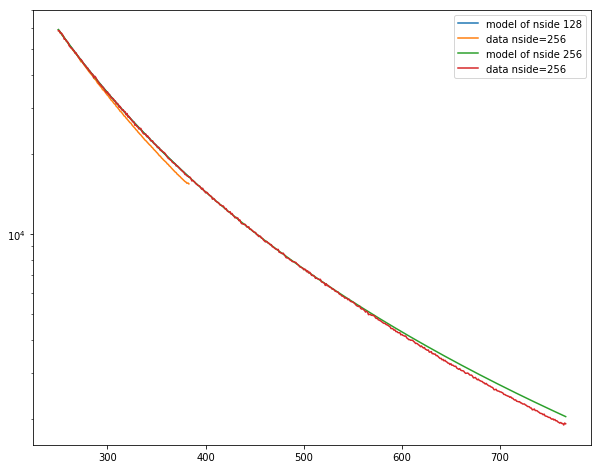

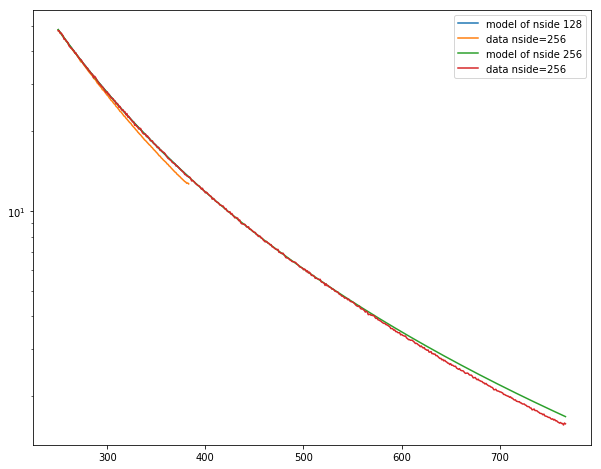

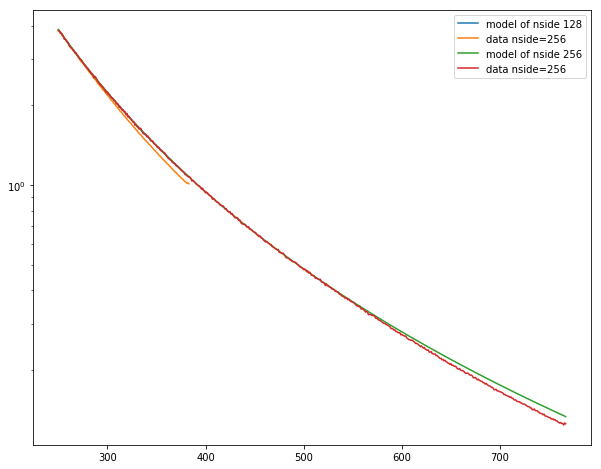

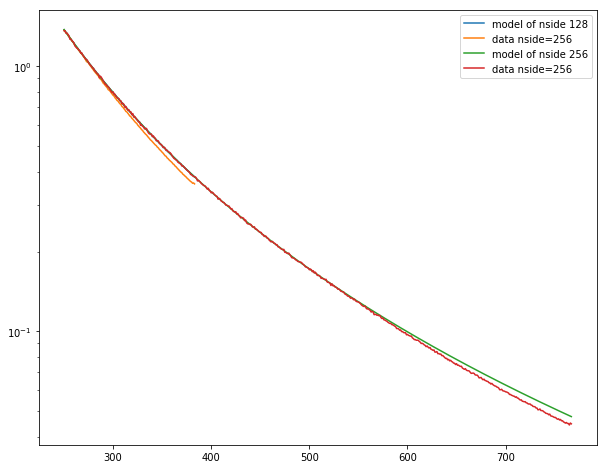

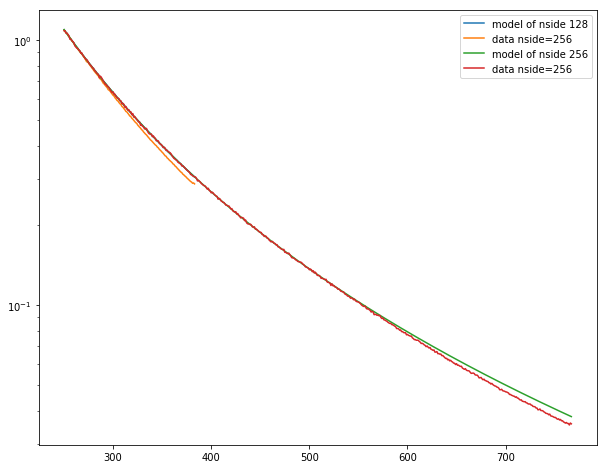

In [124]:
for i in range(len(freqs)):
    figure(figsize=(10,8))
    semilogy(ells[250:], model[i][250:], label='model of nside 128')
    semilogy(ells[250:], PS_2d_const_mean[i][250:], label='data nside=256')
    semilogy(ells1[250:], model1[i][250:], label='model of nside 256')
    semilogy(ells1[250:], PS_2d_256[i][250:], label='data nside=256')
    legend();


In [103]:
#yep, so exactly the same issue as before, just pushed to a higher ell.